# Preprocesamiento de Datos para Detección de Fraude

Este notebook realiza el preprocesamiento de los datos de transacciones de tarjetas de crédito para prepararlos para el modelado.

## Contenido

1. Carga de datos
2. Limpieza de datos
3. Transformación de características
4. Manejo de outliers
5. División de datos en conjuntos de entrenamiento y prueba
6. Balanceo de clases
7. Escalado de características
8. Guardado de datos procesados

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

# Configurar visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Añadir directorio raíz al path para importar módulos personalizados
sys.path.append('..')

# Importar funciones personalizadas
from src.config import (
    RAW_DATA_FILE, PROCESSED_DATA_DIR, RANDOM_STATE,
    X_TRAIN_FILE, X_TEST_FILE, Y_TRAIN_FILE, Y_TEST_FILE, SCALER_FILE
)
from src.data_prep import (
    load_data, check_data_quality, handle_missing_values,
    transform_features, handle_outliers, split_data,
    balance_classes, scale_features, save_processed_data
)
from src.utils import timer_decorator

## 1. Carga de datos

In [2]:
# Cargar datos
print("Cargando datos...")
df = load_data(RAW_DATA_FILE)

# Mostrar información básica
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
print(f"Tipos de datos:\n{df.dtypes}")

# Mostrar las primeras filas
df.head()

Cargando datos...
Cargando datos desde c:\Projects\Credit_fraud\data\raw\creditcard.csv...
Datos cargados: 284807 filas y 31 columnas.
Función load_data ejecutada en 1.69 segundos

Dimensiones del dataset: (284807, 31)
Columnas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Tipos de datos:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Limpieza de datos

In [3]:
# Verificar calidad de los datos
print("Verificando calidad de los datos...")
quality_report = check_data_quality(df)

# Mostrar resumen de calidad
print(f"\nValores nulos: {quality_report['null_values']}")
print(f"Valores duplicados: {quality_report['duplicate_rows']}")
print(f"Valores infinitos: {quality_report['infinite_values']}")

Verificando calidad de los datos...
Verificando calidad de los datos...
Valores nulos: 0
Columnas con valores nulos: []
Filas duplicadas: 1081
Valores infinitos: 0
Distribución de clases:
  Clase 0: 99.83%
  Clase 1: 0.17%
Función check_data_quality ejecutada en 0.95 segundos

Valores nulos: 0
Valores duplicados: 1081
Valores infinitos: 0


In [4]:
# Manejar valores faltantes si existen
if quality_report['null_values'] > 0 or quality_report['infinite_values'] > 0:
    print("Manejando valores faltantes e infinitos...")
    df = handle_missing_values(df)
    print(f"Dimensiones después de manejar valores faltantes: {df.shape}")
else:
    print("No hay valores faltantes o infinitos que manejar.")

# Eliminar duplicados si existen
if quality_report['duplicate_rows'] > 0:
    print("Eliminando filas duplicadas...")
    df = df.drop_duplicates()
    print(f"Dimensiones después de eliminar duplicados: {df.shape}")
else:
    print("No hay filas duplicadas que eliminar.")

No hay valores faltantes o infinitos que manejar.
Eliminando filas duplicadas...
Dimensiones después de eliminar duplicados: (283726, 31)


## 3. Transformación de características

In [5]:
# Transformar características
print("Transformando características...")
df_transformed = transform_features(df)

# Mostrar las nuevas características
new_features = set(df_transformed.columns) - set(df.columns)
print(f"\nNuevas características creadas: {new_features}")

# Mostrar las primeras filas del dataframe transformado
df_transformed.head()

Transformando características...
Transformando características...
Transformada Amount con logaritmo (Amount_Log)
Transformada Time a hora del día (Hour)
Creada variable categórica para período del día (Day_Period)
Creadas características de interacción (V1_V2, V1_V3, V2_V3)
Creadas características polinómicas (V14_Sq, V17_Sq)
Creada característica de distancia en espacio PCA (PCA_Dist)
Creadas variables dummy para Day_Period
Total de nuevas características creadas: 13
Nuevas características: {'Hour', 'Period_Noche', 'Period_Mañana', 'V2_V3', 'Day_Period', 'Period_Tarde', 'V1_V2', 'PCA_Dist', 'V17_Sq', 'Period_Madrugada', 'Amount_Log', 'V14_Sq', 'V1_V3'}
Función transform_features ejecutada en 0.13 segundos

Nuevas características creadas: {'Hour', 'Period_Noche', 'Period_Mañana', 'V2_V3', 'Day_Period', 'Period_Tarde', 'V1_V2', 'PCA_Dist', 'V17_Sq', 'Period_Madrugada', 'Amount_Log', 'V14_Sq', 'V1_V3'}


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V1_V2,V1_V3,V2_V3,V14_Sq,V17_Sq,PCA_Dist,Period_Madrugada,Period_Mañana,Period_Tarde,Period_Noche
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.098968,-3.448942,-0.184598,0.096826,0.043252,3.209548,True,False,False,False
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.317214,0.198421,0.044309,0.020670,0.013180,1.312829,True,False,False,False
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,1.820416,-2.408646,-2.376390,0.027538,1.232032,2.680089,True,False,False,False
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.178979,-1.732519,-0.332109,0.082900,0.467983,2.219953,True,False,False,False
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-1.016624,-1.793776,1.359367,1.253661,0.056185,2.199703,True,False,False,False


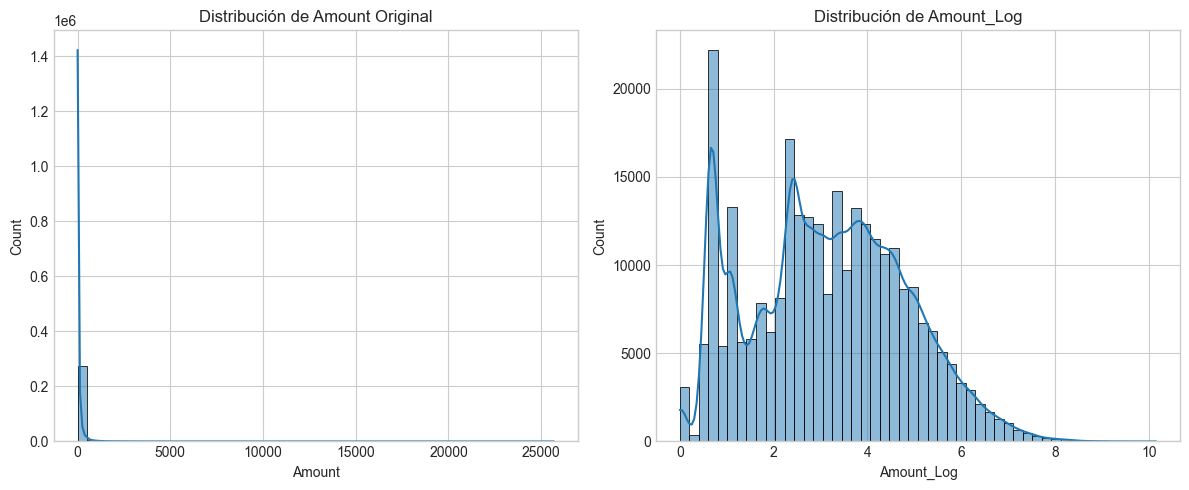

In [6]:
# Visualizar distribución de características transformadas
if 'Amount_Log' in df_transformed.columns:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['Amount'], bins=50, kde=True)
    plt.title('Distribución de Amount Original')
    plt.xlabel('Amount')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_transformed['Amount_Log'], bins=50, kde=True)
    plt.title('Distribución de Amount_Log')
    plt.xlabel('Amount_Log')
    
    plt.tight_layout()
    plt.show()

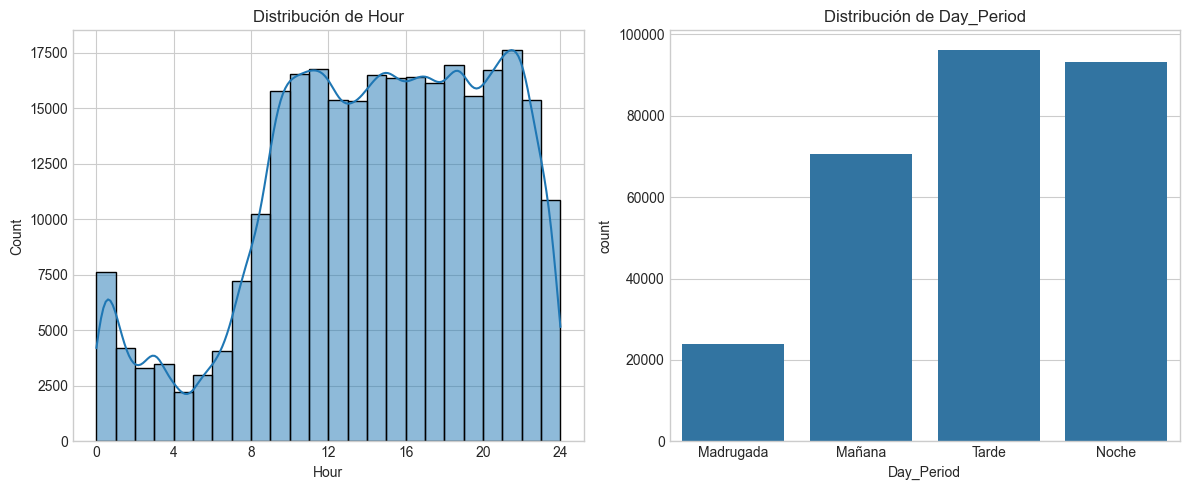

In [7]:
# Visualizar distribución de características temporales si existen
if 'Hour' in df_transformed.columns:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df_transformed['Hour'], bins=24, kde=True)
    plt.title('Distribución de Hour')
    plt.xlabel('Hour')
    plt.xticks(range(0, 25, 4))
    
    if 'Day_Period' in df_transformed.columns:
        plt.subplot(1, 2, 2)
        sns.countplot(x='Day_Period', data=df_transformed)
        plt.title('Distribución de Day_Period')
        plt.xlabel('Day_Period')
    
    plt.tight_layout()
    plt.show()

## 4. Manejo de outliers

Analizando outliers en Amount...


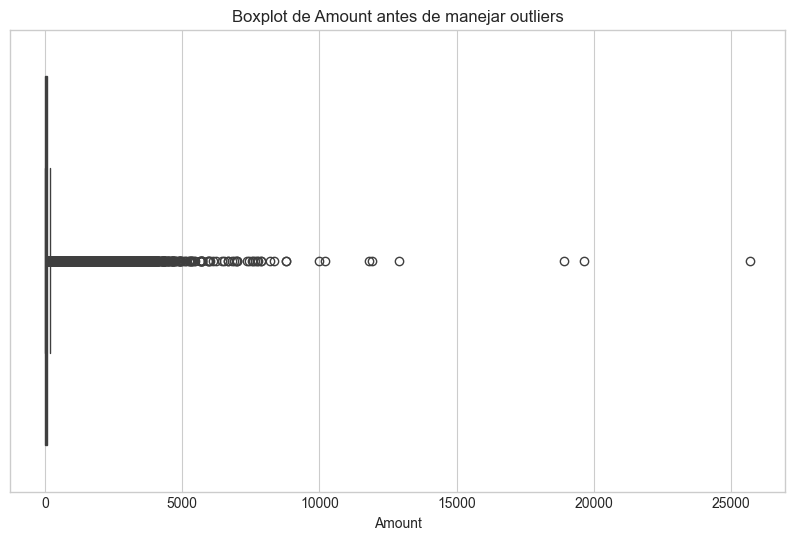

In [8]:
# Detectar outliers en Amount
print("Analizando outliers en Amount...")
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_transformed['Amount'])
plt.title('Boxplot de Amount antes de manejar outliers')
plt.xlabel('Amount')
plt.show()

Manejando outliers...
Manejando outliers...
Columna V1: 6948 outliers (2.45%)
  Aplicado recorte con límites: [-4.26, 4.66]
Columna V2: 13390 outliers (4.72%)
  Aplicado recorte con límites: [-2.70, 2.90]
Columna V3: 3306 outliers (1.17%)
  Aplicado recorte con límites: [-3.76, 3.90]
Columna V4: 11094 outliers (3.91%)
  Aplicado recorte con límites: [-3.23, 3.12]
Columna V5: 12221 outliers (4.31%)
  Aplicado recorte con límites: [-2.64, 2.57]
Columna V6: 22886 outliers (8.07%) - No tratados por ser ≥ 5%
Columna V7: 8839 outliers (3.12%)
  Aplicado recorte con límites: [-2.24, 2.25]
Columna V8: 23904 outliers (8.43%) - No tratados por ser ≥ 5%
Columna V9: 8199 outliers (2.89%)
  Aplicado recorte con límites: [-2.50, 2.46]
Columna V10: 9345 outliers (3.29%)
  Aplicado recorte con límites: [-2.02, 1.94]
Columna V11: 735 outliers (0.26%)
  Aplicado recorte con límites: [-3.01, 2.99]
Columna V12: 15282 outliers (5.39%) - No tratados por ser ≥ 5%
Columna V13: 3362 outliers (1.18%)
  Aplicado

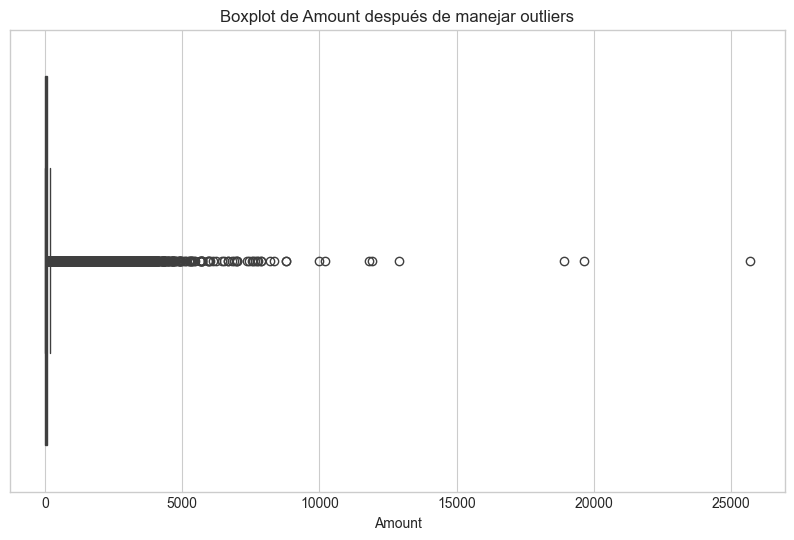


Dimensiones después de manejar outliers: (283726, 44)


In [9]:
# Manejar outliers
print("Manejando outliers...")
df_no_outliers = handle_outliers(df_transformed)

# Verificar cambios en la distribución después de manejar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_no_outliers['Amount'])
plt.title('Boxplot de Amount después de manejar outliers')
plt.xlabel('Amount')
plt.show()

print(f"\nDimensiones después de manejar outliers: {df_no_outliers.shape}")

## 5. División de datos en conjuntos de entrenamiento y prueba

In [10]:
# Dividir datos en conjuntos de entrenamiento y prueba
print("Dividiendo datos en conjuntos de entrenamiento y prueba...")
X_train, X_test, y_train, y_test = split_data(df_no_outliers)

print(f"\nDimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dividiendo datos en conjuntos de entrenamiento y prueba...
Dividiendo datos en conjuntos de entrenamiento (80%) y prueba (20%)...
X_train: 226980 muestras, 43 características
X_test: 56746 muestras, 43 características
Distribución de clases en conjunto de entrenamiento:
  Clase 0: 99.83%
  Clase 1: 0.17%
Distribución de clases en conjunto de prueba:
  Clase 0: 99.83%
  Clase 1: 0.17%
Función split_data ejecutada en 0.23 segundos

Dimensiones de X_train: (226980, 43)
Dimensiones de X_test: (56746, 43)
Dimensiones de y_train: (226980,)
Dimensiones de y_test: (56746,)


In [11]:
# Verificar distribución de clases en conjuntos de entrenamiento y prueba
train_class_dist = pd.Series(y_train).value_counts(normalize=True) * 100
test_class_dist = pd.Series(y_test).value_counts(normalize=True) * 100

print("Distribución de clases en conjunto de entrenamiento:")
for cls, pct in train_class_dist.items():
    print(f"  Clase {cls}: {pct:.2f}%")

print("\nDistribución de clases en conjunto de prueba:")
for cls, pct in test_class_dist.items():
    print(f"  Clase {cls}: {pct:.2f}%")

Distribución de clases en conjunto de entrenamiento:
  Clase 0: 99.83%
  Clase 1: 0.17%

Distribución de clases en conjunto de prueba:
  Clase 0: 99.83%
  Clase 1: 0.17%


## 6. Balanceo de clases

In [12]:
# Balancear clases en conjunto de entrenamiento
print("Balanceando clases en conjunto de entrenamiento...")
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

print(f"\nDimensiones de X_train después de balanceo: {X_train_balanced.shape}")
print(f"Dimensiones de y_train después de balanceo: {y_train_balanced.shape}")

Balanceando clases en conjunto de entrenamiento...
Balanceando clases con SMOTE...
Distribución original:
  Clase 0: 226602 (99.83%)
  Clase 1: 378 (0.17%)
Detectadas 1 columnas categóricas: ['Day_Period']
Aplicando one-hot encoding a columnas categóricas antes de SMOTE...


  File "C:\Users\furio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

SMOTE aplicado exitosamente a datos numéricos.
Distribución después de SMOTE:
  Clase 0: 226602 (50.00%)
  Clase 1: 226602 (50.00%)
Función balance_classes ejecutada en 0.87 segundos

Dimensiones de X_train después de balanceo: (453204, 46)
Dimensiones de y_train después de balanceo: (453204,)


Distribución de clases después del balanceo:
  Clase 0: 50.00%
  Clase 1: 50.00%


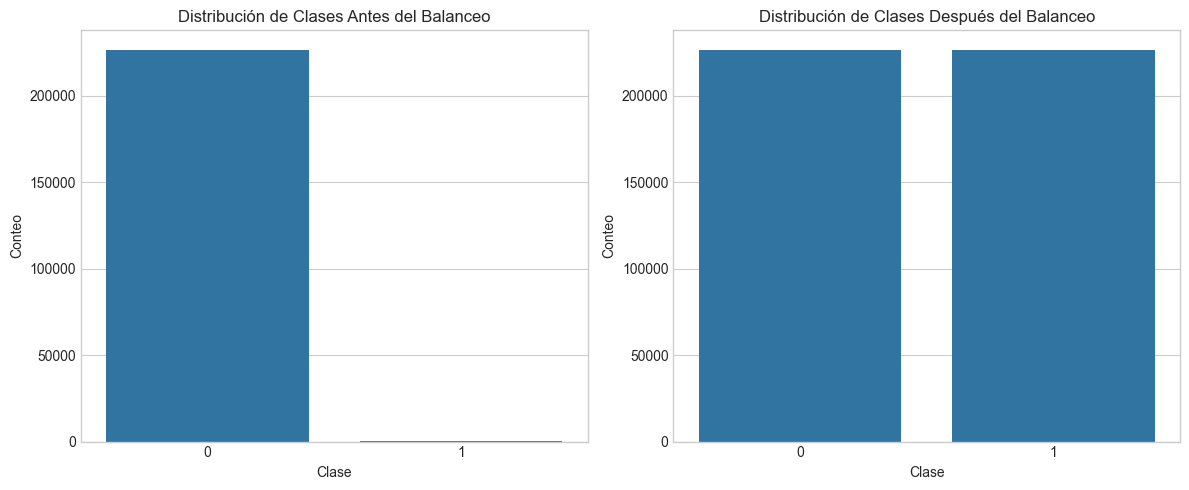

In [13]:
# Verificar distribución de clases después del balanceo
balanced_class_dist = pd.Series(y_train_balanced).value_counts(normalize=True) * 100

print("Distribución de clases después del balanceo:")
for cls, pct in balanced_class_dist.items():
    print(f"  Clase {cls}: {pct:.2f}%")

# Visualizar distribución de clases antes y después del balanceo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribución de Clases Antes del Balanceo')
plt.xlabel('Clase')
plt.ylabel('Conteo')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced)
plt.title('Distribución de Clases Después del Balanceo')
plt.xlabel('Clase')
plt.ylabel('Conteo')

plt.tight_layout()
plt.show()

## 7. Escalado de características

In [14]:
# Escalar características
print("Escalando características...")
X_train_scaled, X_test_scaled, scaler = scale_features(X_train_balanced, X_test)

print(f"\nDimensiones de X_train_scaled: {X_train_scaled.shape}")
print(f"Dimensiones de X_test_scaled: {X_test_scaled.shape}")

Escalando características...
Escalando características con standard scaler...
Detectada discrepancia de columnas entre conjuntos de entrenamiento y prueba.
Columnas solo en entrenamiento: {'Day_Period_Mañana', 'Day_Period_Madrugada', 'Day_Period_Noche', 'Day_Period_Tarde'}
Columnas solo en prueba: {'Day_Period'}
Usando solo las 42 columnas comunes para escalar.
Características escaladas. Rango típico: [-3.0, 3.0]
Función scale_features ejecutada en 1.45 segundos

Dimensiones de X_train_scaled: (453204, 42)
Dimensiones de X_test_scaled: (56746, 42)


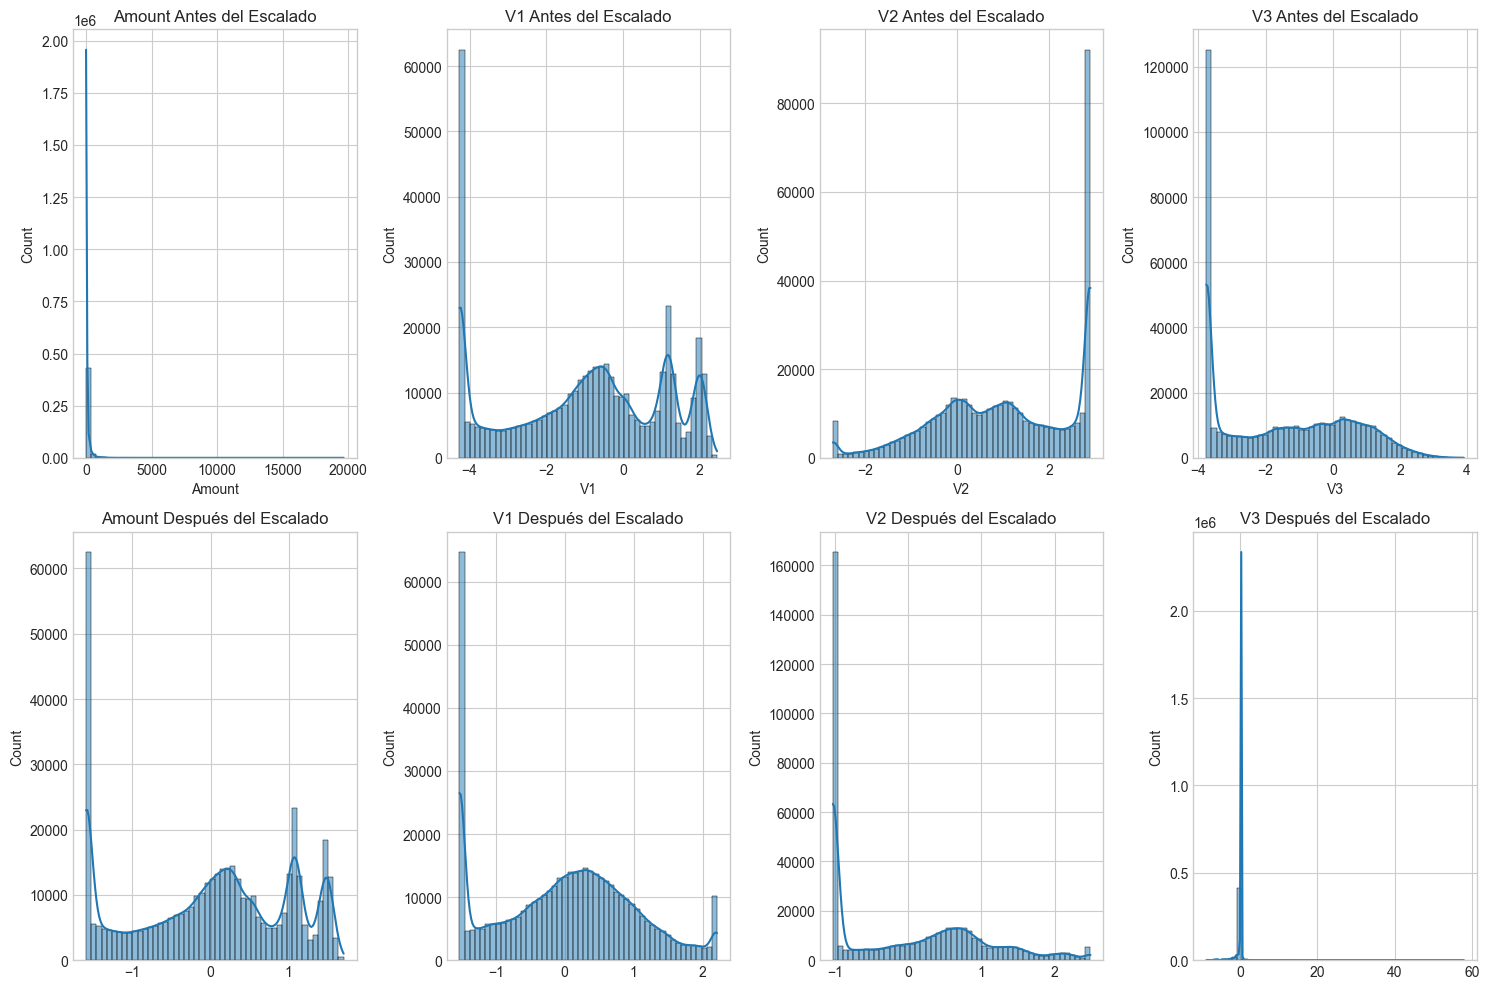

In [15]:
# Visualizar efecto del escalado en algunas características
features_to_plot = ['Amount', 'V1', 'V2', 'V3']
n_features = len(features_to_plot)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    feature_idx = X_train_balanced.columns.get_loc(feature)
    
    plt.subplot(2, n_features, i+1)
    sns.histplot(X_train_balanced[feature], bins=50, kde=True)
    plt.title(f'{feature} Antes del Escalado')
    
    plt.subplot(2, n_features, i+n_features+1)
    sns.histplot(X_train_scaled[:, feature_idx], bins=50, kde=True)
    plt.title(f'{feature} Después del Escalado')

plt.tight_layout()
plt.show()

## 8. Guardado de datos procesados

In [16]:
# Obtener las columnas comunes entre X_train_balanced y X_test
if isinstance(X_train_balanced, pd.DataFrame) and isinstance(X_test, pd.DataFrame):
    train_cols = set(X_train_balanced.columns)
    test_cols = set(X_test.columns)
    common_cols = list(train_cols.intersection(test_cols))
    feature_names_used = common_cols
else:
    # Si ya son arrays NumPy, necesitamos crear nombres genéricos
    feature_names_used = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]

# Guardar datos procesados
print("Guardando datos procesados...")
save_processed_data(X_train_scaled, X_test_scaled, y_train_balanced, y_test, scaler, feature_names_used)

print(f"\nDatos guardados en {PROCESSED_DATA_DIR}")
print(f"X_train guardado en {X_TRAIN_FILE}")
print(f"X_test guardado en {X_TEST_FILE}")
print(f"y_train guardado en {Y_TRAIN_FILE}")
print(f"y_test guardado en {Y_TEST_FILE}")
print(f"Scaler guardado en {SCALER_FILE}")

Guardando datos procesados...
Guardando datos procesados...
Datos guardados en c:\Projects\Credit_fraud\data\processed
X_train guardado en c:\Projects\Credit_fraud\data\processed\X_train.csv
X_test guardado en c:\Projects\Credit_fraud\data\processed\X_test.csv
y_train guardado en c:\Projects\Credit_fraud\data\processed\y_train.csv
y_test guardado en c:\Projects\Credit_fraud\data\processed\y_test.csv
Scaler guardado en c:\Projects\Credit_fraud\data\processed\standard_scaler.pkl
Metadatos guardados en c:\Projects\Credit_fraud\data\processed\metadata.txt
Función save_processed_data ejecutada en 24.94 segundos

Datos guardados en c:\Projects\Credit_fraud\data\processed
X_train guardado en c:\Projects\Credit_fraud\data\processed\X_train.csv
X_test guardado en c:\Projects\Credit_fraud\data\processed\X_test.csv
y_train guardado en c:\Projects\Credit_fraud\data\processed\y_train.csv
y_test guardado en c:\Projects\Credit_fraud\data\processed\y_test.csv
Scaler guardado en c:\Projects\Credit_frau

## Resumen del Preprocesamiento

En este notebook, hemos realizado los siguientes pasos de preprocesamiento:

1. **Carga de datos**: Cargamos el dataset de transacciones de tarjetas de crédito.

2. **Limpieza de datos**: Verificamos y manejamos valores faltantes, infinitos y duplicados.

3. **Transformación de características**: Aplicamos transformaciones como logaritmo a `Amount` y convertimos `Time` a características temporales más informativas.

4. **Manejo de outliers**: Detectamos y tratamos outliers en las características numéricas.

5. **División de datos**: Separamos los datos en conjuntos de entrenamiento y prueba, manteniendo la proporción de clases.

6. **Balanceo de clases**: Aplicamos SMOTE para balancear las clases en el conjunto de entrenamiento.

7. **Escalado de características**: Aplicamos escalado estándar a las características para mejorar el rendimiento de los algoritmos.

8. **Guardado de datos**: Guardamos los datos procesados para su uso en el entrenamiento y evaluación de modelos.

Los datos están ahora listos para ser utilizados en el entrenamiento de modelos de machine learning para la detección de fraude.